In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import os, sys
import glob
import warnings
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

import skimage

from fastai.vision import *
from fastai.vision.models import *

from models import model_list
from utils.databunch import get_data_bunch

In [3]:
def show_image(impath, label=True):
    plt.figure(figsize=(18,6))
    plt.imshow(skimage.io.imread(impath))
    if label:
        plt.imshow(skimage.io.imread(impath.replace('train_images', 'train_masks').replace('.jpg', '.png')), alpha=0.2)
    
    
data_df = pd.read_csv('./data/train.csv')
data_df

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN
5,00031f466.jpg_2,NaN
6,00031f466.jpg_3,NaN
7,00031f466.jpg_4,NaN
8,000418bfc.jpg_1,NaN
9,000418bfc.jpg_2,NaN


## Mask Generation

In [9]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [10]:
for i in range(0,len(data_df),4):
    r1 = data_df['EncodedPixels'][i]
    r2 = data_df['EncodedPixels'][i+1]    
    r3 = data_df['EncodedPixels'][i+2]    
    r4 = data_df['EncodedPixels'][i+3]
    if (pd.isnull(r1)+pd.isnull(r2)+pd.isnull(r3)+pd.isnull(r4)) < 2:
        print(i)

43212
47104


In [11]:
def addmask(fullmask, rle, def_id):
    rle = '' if pd.isnull(rle) else rle
    mask = rle2mask(rle, (256, 1600, 3))
    assert(fullmask[mask!=0].sum() == 0)
    fullmask[mask!=0] = def_id
    return fullmask

In [12]:
plt.figure(figsize=(16,8))
for i in tqdm(range(0, len(data_df), 4)):
#     i=47104
    id = data_df.loc[i, 'ImageId_ClassId'].replace('.jpg', '')
    img = io.imread('./data/train_images/' + id[:-2] + '.jpg')
#     plt.imshow(img)
#     print(img.shape)
    mask = np.zeros(img.shape[:-1], dtype='uint8')
    mask = addmask(mask, data_df.loc[i, 'EncodedPixels'], 1)
    mask = addmask(mask, data_df.loc[i+1, 'EncodedPixels'], 2)
    mask = addmask(mask, data_df.loc[i+2, 'EncodedPixels'], 3)
    mask = addmask(mask, data_df.loc[i+3, 'EncodedPixels'], 4)
    
    readmask = io.imread('./data/train_masks/' + id[:-2] + '.png', mask)
    assert(np.array_equal(mask, readmask))

#     print(mask.sum())
#     plt.imshow(mask, alpha=0.2)
#     break
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         io.imsave('./data/train_masks/' + id[:-2] + '.png', mask)

<Figure size 1152x576 with 0 Axes>

## Dataset

In [4]:
split_df = pd.read_csv('./data/split.csv')
# valid_files = set(split_df[split_df['is_valid'] == True]['ImageId_ClassId'])

In [28]:
data = get_data_bunch(split_df, batch_size=8, load_valid_crops=False)
data

ImageDataBunch;

Train: LabelList (10054 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: .;

Valid: LabelList (2514 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: .;

Test: None

In [87]:
bt = next(iter(data.train_ds))

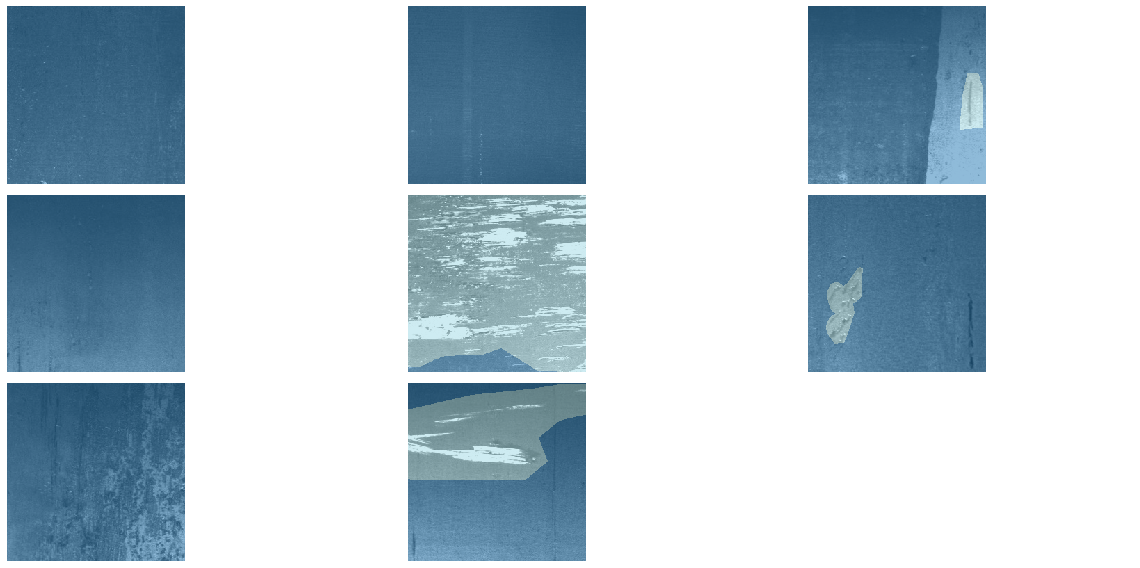

In [31]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(18,8))

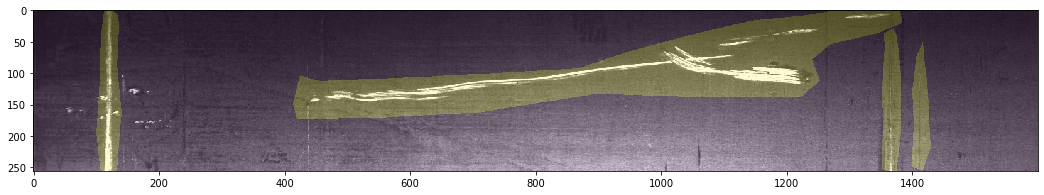

In [22]:
show_image(str(data.valid_ds.items[7]))

## Net

In [ ]:
from models.mxresnet import mx

In [69]:
Net = getattr(model_list, 'mxresnet34')

In [70]:
Net()

MXResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [55]:
Unt = DynamicUnet(encoder=nn.Sequential(*[i for i in Net().children()][:-3]), n_classes=4, img_size=(256, 256), blur=False, blur_final=True, self_attention=False, y_range=None, last_cross=True, bottle=False)

In [61]:
Unt = Unt.cuda()
Unt

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): Sequential(
              (0): Conv2d(64, 64, kernel_size=

In [65]:
a = torch.zeros((8, 3, 256, 256)).cuda()

In [66]:
a.type()

'torch.cuda.FloatTensor'

In [67]:
o = Unt(a)

In [68]:
o.shape

torch.Size([8, 4, 256, 256])

In [77]:
from models.model_list import UnetMxResnet

In [83]:
Unet = UnetMxResnet('mxresnet34', img_size=(256, 256))

In [81]:
Unet

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): Sequential(
              (0): Conv2d(64, 64, kernel_size=

In [ ]:
from fastai.torch_core import *

In [84]:
Rank0Tensor

<function typing.NewType.<locals>.new_type(x)>

In [86]:
a.unique()

tensor([0.], device='cuda:0')

In [116]:
l = skimage.io.imread('./data/train_masks/0088260da.png')
l = l[:, :, np.newaxis]
(l!=0).sum()

86663

In [137]:
def make_one_hot(label):
    label = torch.cat([label==1, label==2, label==3, label==4], axis=1)
    return label

In [119]:
ohl = np.concatenate([l==1, l==2, l==3, l==4], axis=2)

In [120]:
ohl.sum()

86663

In [121]:
ohl.shape

(256, 1600, 4)

In [135]:
l = bt[1]

In [136]:
l.shape

torch.Size([1, 256, 256])

In [153]:
l.data.sum()

tensor(3073)

In [155]:
label = torch.cat([l.data==1, l.data==2, l.data==3, l.data==4], dim=0)

In [156]:
label.shape

torch.Size([4, 256, 256])

In [157]:
label.sum()

tensor(3073)

In [142]:
torch.tensor(1)

tensor(1)

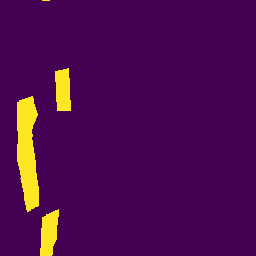

In [140]:
l.